# Import Libraries and Constants

In [31]:
import os
import re
import sys
import numpy as np
import pandas as pd
import tempfile
import shutil
import matplotlib.pyplot as plt
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             precision_recall_curve, roc_curve, auc)
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)
from scipy.stats import randint as sp_randint

from imblearn.ensemble import BalancedRandomForestClassifier



In [32]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)



In [33]:
from constants import SERVER_PATH, OUTPUT_PATH, MASKED_RASTERS_DIR, FEATURES_DIR


In [34]:
#output- update this for subsequent runs
output_folder = os.path.join(OUTPUT_PATH[0], 'basic_rf_model')




# Create Stack

In [35]:
# helper function to read tiff files
def read_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1)


In [36]:
# List of paths to the raster files to be used as features
feature_files = [os.path.join(FEATURES_DIR[0], 'lup_10_treemask.tif')]

# Then you can use this list of feature_files to create feature_data_arrays and feature_data_flat:
feature_data_arrays = [read_tiff_image(file_path) for file_path in feature_files]
feature_data_flat = [data_array.flatten() for data_array in feature_data_arrays]

# Path to the y_file
y_file = os.path.join(MASKED_RASTERS_DIR[0], 'deforestation11_20_masked.tif')


In [37]:
feature_files

['/Users/romero61/../../capstone/pyforest/ml_data/output/tree_masked_rasters/lup_10_treemask.tif']

In [38]:
y_file

'/Users/romero61/../../capstone/pyforest/ml_data/output/masked_rasters/deforestation11_20_masked.tif'

In [39]:
# Find the dimensions of all the raster data arrays
raster_shapes = [raster_data.shape for raster_data in feature_data_arrays]

# Check if all raster data arrays have the same dimensions
if len(set(raster_shapes)) > 1:
    print("There are mismatching dimensions:")
    for file_path, raster_shape in zip(raster_files, raster_shapes):
        print(f"File: {file_path}, Shape: {raster_shape}")
else:
    print("All raster data arrays have the same dimensions.")
    # Check the dimensions of all the raster data arrays
    for i, data_array in enumerate(feature_data_arrays):
        print(f"Raster {i}: {data_array.shape}")


All raster data arrays have the same dimensions.
Raster 0: (22512, 20381)


# Stack and Flatten Data

In [40]:
# NoData Value
no_data_value = -1

# Stack the flattened raster data
X_flat = np.column_stack(feature_data_flat)

# Use the y_file obtained from the find_deforestation_file function
y = read_tiff_image(y_file).flatten()

# Remove rows with NoData values
'''checks each row in X_flat and creates a boolean array (valid_rows_X) that has the same number of elements 
as the number of rows in X_flat. Each element in valid_rows_X is True if there is no NoData value in 
the corresponding row of X_flat and False otherwise.'''
valid_rows_X = ~(X_flat == no_data_value).any(axis=1)

'''checks each element in the y array and creates a boolean array (valid_rows_y) that has the same number of 
elements as y. Each element in valid_rows_y is True if the corresponding element in y is not 
equal to the NoData value and False otherwise.'''
valid_rows_y = y != no_data_value

'''checks each element in the y array and creates a boolean array (valid_rows_y) 
that has the same number of elements as y. Each element in valid_rows_y is True if the corresponding element 
in y is not equal to the NoData value and False otherwise.'''
valid_rows = valid_rows_X & valid_rows_y

'''creates a new array X_cleaned by selecting only the rows in X_flat that 
correspond to the True elements in valid_rows.'''
X_cleaned = X_flat[valid_rows]

'''creates a new array y_cleaned by selecting only the elements in y that correspond 
to the True elements in valid_rows.'''
y_cleaned = y[valid_rows]
 

To ensure your data cleaning steps have been applied correctly, you can check the following:

**NoData values have been removed:** You should confirm that there are no NoData values in your cleaned data. This can be done by asserting that there are no occurrences of no_data_value in X_cleaned and y_cleaned.

In [41]:
assert not (X_cleaned == no_data_value).any()
assert not (y_cleaned == no_data_value).any()


These assertions will throw an error if there is a NoData value in X_cleaned or y_cleaned

**Dimensions are correct:** The shapes of X_cleaned and y_cleaned should match along the row dimension (the first dimension for 2D array X_cleaned and the only dimension for 1D array y_cleaned).

In [42]:
print("Shape of X_cleaned:", X_cleaned.shape)
print("Shape of y_cleaned:", y_cleaned.shape)


Shape of X_cleaned: (29112890, 1)
Shape of y_cleaned: (29112890,)


Make sure the number of rows in X_cleaned equals the number of elements in y_cleaned.

**Confirm that the valid rows have been correctly identified:** You can do this by checking that the number of True values in valid_rows equals the number of rows in X_cleaned (or the number of elements in y_cleaned).

In [43]:
assert valid_rows.sum() == X_cleaned.shape[0]


# Split the data into training and testing sets


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=42, stratify=y_cleaned)


In [45]:
print("Shape of y_test:", y_test.shape)


Shape of y_test: (8733867,)


# Class Balance Check

In [46]:
# Create pandas Series from your labels
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)
y_cleaned_series = pd.Series(y_cleaned)

# Print balance of classes in training, testing, and whole dataset
print("Training data balance:\n", y_train_series.value_counts(normalize=True))
print("Testing data balance:\n", y_test_series.value_counts(normalize=True))
print("Whole dataset balance:\n", y_cleaned_series.value_counts(normalize=True))


Training data balance:
 0    0.747872
1    0.252128
dtype: float64
Testing data balance:
 0    0.747872
1    0.252128
dtype: float64
Whole dataset balance:
 0    0.747872
1    0.252128
dtype: float64


The balance of your dataset seems to be roughly the same in both the training and testing sets, with about 80.6% of the instances belonging to class 0 (no deforestation) and 19.3% to class 1 (deforestation). This shows that the classes are quite imbalanced. Machine learning algorithms, including Random Forest, may have a bias towards the majority class in such situations, which could be one of the reasons why your model is not performing well on the minority class.

LUP_10 Value: 1.0, Count: 4156080
LUP_10 Value: 2.0, Count: 12844684
LUP_10 Value: 3.0, Count: 11556539
LUP_10 Value: 4.0, Count: 555587
-----------------


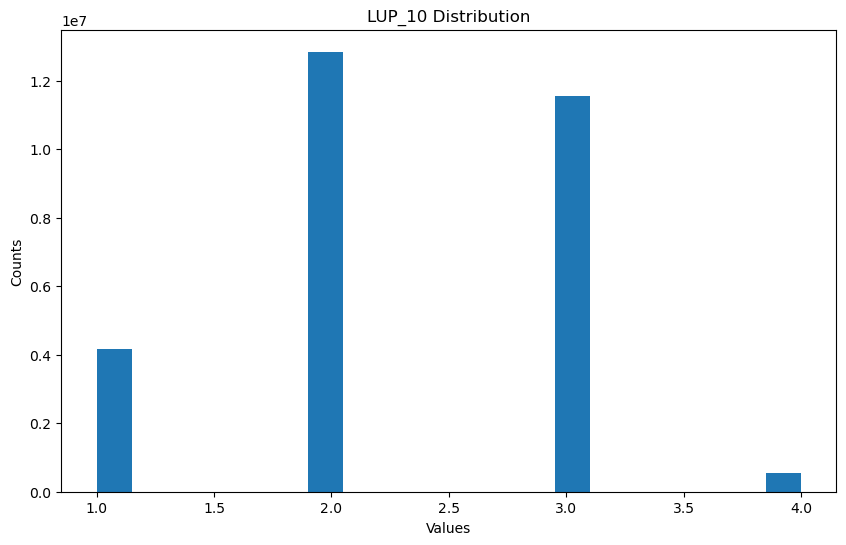

In [47]:
# Create a list to hold your feature file paths


# Define the labels for your features
#feature_labels = ['LUP_10', 'Precipitation', 'River','Road', 'Soil']
feature_labels = ['LUP_10']



    
for i, feature in enumerate(feature_labels):
    unique_values, counts = np.unique(X_cleaned[:, i], return_counts=True)
    
    # Print the counts for each unique value
    for value, count in zip(unique_values, counts):
        print(f'{feature} Value: {value}, Count: {count}')

    print('-----------------')
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(X_cleaned[:, i], bins=20)
    plt.title(f'{feature} Distribution')
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.show()


# Random Forest model using BalancedRandomForestClassifier:

In [24]:
brfc = BalancedRandomForestClassifier(random_state=42, class_weight= 'balanced', sampling_strategy='not majority')
'''# Define new hyperparameter options
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}'''

# Define a basic parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # number of trees in the forest
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 50, 100, 150, 200], # maximum depth of the tree
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set scoring metrics
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator = brfc,
    param_distributions=param_grid,
    scoring=scoring,
    refit='f1',  # because we are interested in maximizing f1_score
    cv=5,
    n_jobs=19,
    verbose=0,
    n_iter=100,  # number of parameter settings that are sampled
    random_state=42  # for reproducibility
)

# Create the GridSearchCV object
'''grid_search = GridSearchCV(
    estimator = brfc,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',  # because we are interested in maximizing f1_score
    cv=5,
    n_jobs=19,
    verbose=0
)'''



In [ ]:
# Fit GridSearch to the BalancedRandomForestClassifier data
grid_search.fit(X_train, y_train)
#Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
def is_fitted(estimator):
    try:
        getattr(estimator, "estimators_")
        return True
    except AttributeError:
        return False

print(is_fitted(brfc))


In [21]:
grid_search.score


<bound method BaseSearchCV.score of GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(class_weight='balanced',
                                                      random_state=42,
                                                      sampling_strategy='not '
                                                                        'majority'),
             n_jobs=19,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             refit='f1',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})>

In [22]:


# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_estimator = grid_search.best_estimator_

cv_results = grid_search.cv_results_

cv_results_df = pd.DataFrame(grid_search.cv_results_)

scorer = grid_search.scorer_

refit_time = grid_search.refit_time_


Best parameters: {'max_depth': None, 'n_estimators': 50}
Best cross-validation score: 0.4845839150573231


In [44]:
print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)
print("Best estimator:", best_estimator)
print("CV Results:",cv_results_df)
print("Scorer function:", scorer)
print("Refit time (seconds):", refit_time)



Best parameters: {'max_depth': None, 'n_estimators': 50}
Best cross-validation score: 0.4845839150573231
Best estimator: BalancedRandomForestClassifier(class_weight='balanced', n_estimators=50,
                               random_state=42,
                               sampling_strategy='not majority')
CV Results:     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      535.629575      2.330320        31.496318        0.155117   
1     1069.753634      6.405724        56.478282        0.184474   
2     2165.919110     19.817767       154.048608        5.364894   
3      535.728546      3.833532        31.584356        0.071081   
4     1062.729164      4.347988        95.832514        1.050506   
5     2280.197555     96.314744       106.971950        0.609603   
6      563.289992     26.147850        33.580086        2.533693   
7     1133.890707     33.708493       117.828511       21.865802   
8     2208.049586     78.751899       110.331541       12.376744   
9

# Model evaluation performance  metrics 
e.g., confusion matrix, classification report, accuracy, F1-score, etc.

In [24]:
best_model = grid_search.best_estimator_


In [25]:
# Predictions for test data
y_pred = best_model.predict(X_test)


# TESTING DATA Classificatin Report-Confusion Matrix

In [26]:

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1-score (use 'weighted' or 'macro' depending on your problem)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification report:\n", report)


Accuracy: 0.6869900388432683
F1-score: 0.7190388232149647
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.78   9184478
           1       0.36      0.76      0.48   2202051

    accuracy                           0.69  11386529
   macro avg       0.64      0.72      0.63  11386529
weighted avg       0.81      0.69      0.72  11386529



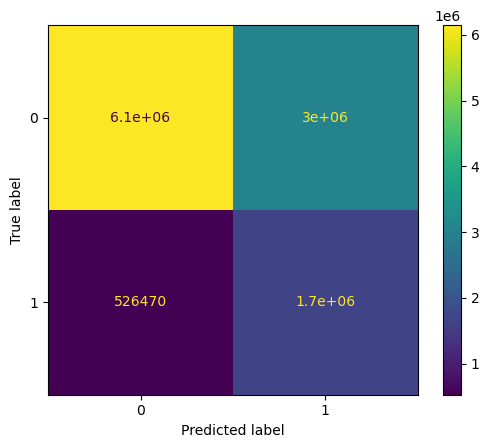

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# TRAINING DATA Classificatin Report-Confusion Matrix

In [27]:
# Predictions for train data
y_pred_train = best_model.predict(X_train)

In [28]:
# Confusion matrix and classification report for train data
train_cm = confusion_matrix(y_train, y_pred_train)
train_cr = classification_report(y_train, y_pred_train)
print("Training confusion matrix:")
print(train_cm)
print("Training classification report:")
print(train_cr)

Training confusion matrix:
[[14341028  7089417]
 [ 1228126  3909994]]
Training classification report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.78  21430445
           1       0.36      0.76      0.48   5138120

    accuracy                           0.69  26568565
   macro avg       0.64      0.72      0.63  26568565
weighted avg       0.81      0.69      0.72  26568565



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
        brfc,
        X_test,
        y_test,
        cmap=plt.cm.Blues)

title = disp.ax_.set_title("Confusion matrix")

print(title)
print(disp.confusion_matrix)

plt.show()

/tmp/ipykernel_3535282/2283730908.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([item[0] for item in sorted_features], rotation=45, ha='right')


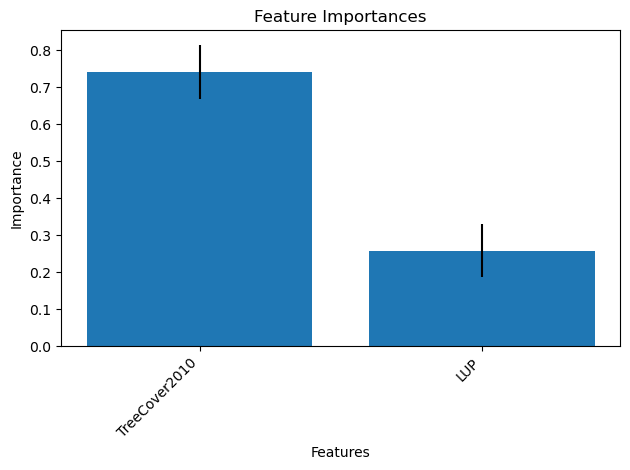

In [33]:
# Calculate feature importances and the standard deviation for those importances
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)


 # list of feature names corresponding to the input bands of your raster stack
feature_names = ['LUP_10', 'Precipitation', 'River','Road', 'Soil']
# Create a sorted list of tuples containing feature names and their importances:
sorted_features = sorted(zip(feature_names, importances, std), key=lambda x: x[1], reverse=True)

# Create a bar chart
fig, ax = plt.subplots()

# Set the feature names as x-axis labels
ax.set_xticklabels([item[0] for item in sorted_features], rotation=45, ha='right')
ax.set_xticks(range(len(sorted_features)))

# Set the y-axis labels as importances
ax.bar(range(len(sorted_features)), [item[1] for item in sorted_features], yerr=[item[2] for item in sorted_features])

# Set the title and labels for the chart
ax.set_title('Feature Importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')

# Display the chart
plt.tight_layout()
plt.show()


# Probabilities for deforestation

In [43]:
y_proba_curve = best_model.predict_proba(X_test)[:, 1]


In [46]:
print("Shape of y_proba_curve:", y_proba_curve.shape)

Shape of y_proba_curve: (11386529,)


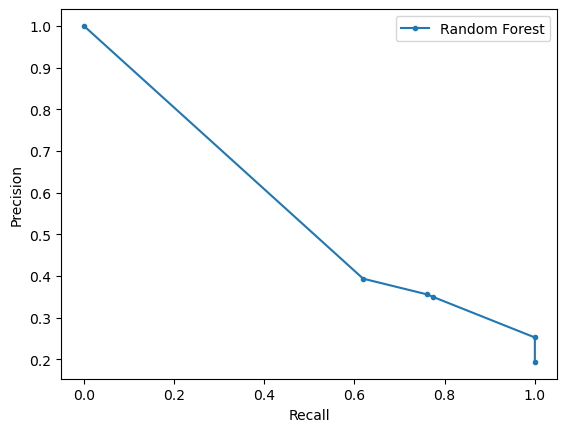

Area under Precision-Recall curve: 0.5569854569566302


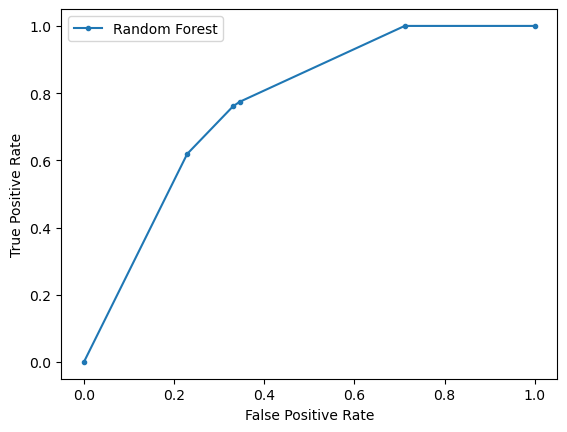

Area under ROC curve: 0.7656242397606493


In [47]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_curve)
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print(f"Area under Precision-Recall curve: {auc(recall, precision)}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_curve)
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f"Area under ROC curve: {auc(fpr, tpr)}")

In [34]:
# Predict probabilities for deforestation events
y_proba = best_model.predict_proba(X_cleaned)[:, 1]


In [35]:
# Predicts the 
# Create a probability raster by filling in the valid pixel values
prob_raster = np.full(y.shape, no_data_value, dtype=np.float32)
prob_raster[valid_rows] = y_proba
prob_raster = prob_raster.reshape(feature_data_arrays[0].shape)


In [48]:
print(y_proba.shape)

(37955094,)


In [50]:
# Save the probability raster as a GeoTIFF file
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file = os.path.join(output_folder, "deforestation_prob_balanced.tiff")

with rasterio.open(y_file) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

prob_raster_reshaped = prob_raster.reshape((1, prob_raster.shape[0], prob_raster.shape[1]))

with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write_band(1, prob_raster_reshaped[0])




# Tuning Strategies

In [ ]:
# Randomized Search
# Set the range of values for each hyperparameter
'''param_dist = {
    "n_estimators": sp_randint(100, 300),
    'criterion': ['gini',],
    'max_features': ['sqrt', None],
    "max_depth": sp_randint(1, 20),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 11),
    "bootstrap": [True],
    'class_weight': ['balanced']
}

# Instantiate the RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=20, cv=5, random_state=0, n_jobs=19
)'''
